# Multiple passes of laser through crystal

_____

#### Imports

In [1]:
import sys, time
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import drift
from rslaser.optics import crystal

import scipy.constants as const

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

### Crystal and Laser Initialization

In [2]:
# specify parameters
params = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        nslice = 10,
        nx_slice = 32,
        ny_slice = 32,
)

gamma = np.sqrt(0.001/1.76)
L_cryst = 0.025 / 3.0
l_scale = 0.06
hc_ev_um = 1.23984198   # hc [eV*um]
phLambda = hc_ev_um / 1.5498 * 1e-6

crystal_params = PKDict(length = 2.5/100.0,  # [m]
                        l_scale = 0.06,
                        nslice = 1,
                        #n0 = [1.00 for _ in range(1)],
                        #n2 = [0.0001 for _ in range(1)],
                        #pump_energy = 6.0,
                                
                        #A = np.cos(gamma*L_cryst),
                        #B = (1/gamma)*np.sin(gamma*L_cryst),
                        #C = -gamma*np.sin(gamma*L_cryst),
                        #D = np.cos(gamma*L_cryst),
)

prop_type = 'gain_calc' #'abcd_lct' #'n0n2_lct' #'n0n2_srw' #'gain_calc'

gain = 1
num_propagate = 3

# Maximum value is num_propagate
prop_array = np.array([0, num_propagate])

## Propagation


Propagation Type:  gain_calc 
Gain:  1 


Total number excited states in crystal,  0  propagations:  1.098671516590698e+16

Propagating  10 laser slices through  1  crystal slices

Slice  0

Interp pop_inversion:
Mesh original total:  4.5001585319554996e+24
  decreasing mesh size
Mesh post-interp total:  3.026999279620329e+24

Interp n_photons:
Mesh original total:  80224577414031.14
Mesh post-interp total:  80224577414031.14

Interp change_pop_inversion:
Mesh original total:  -1.0450800934445886e+21
  increasing mesh size
Mesh post-interp total:  -1.554424764265017e+21

Slice  1

Interp pop_inversion:
Mesh original total:  4.498604107191234e+24
  decreasing mesh size
Mesh post-interp total:  3.0259849253703307e+24

Interp n_photons:
Mesh original total:  324907780701044.94
Mesh post-interp total:  324907780701044.94

Interp change_pop_inversion:
Mesh original total:  -4.2280101312360004e+21
  increasing mesh size
Mesh post-interp total:  -6.288562796874082e+21

Slice  2

Interp pop_i

Text(0.5, 1.0, 'Longitudinal Photon Distribution')

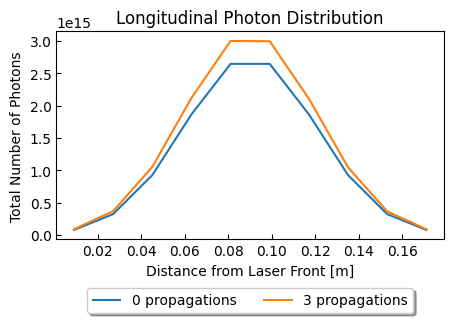

In [3]:
e_crystal = crystal.Crystal(crystal_params)
nslices_crystal = len(e_crystal.slice)

# Assume all crystal slices have same cell volume
dx = (e_crystal.slice[0].pop_inversion_xfin-e_crystal.slice[0].pop_inversion_xstart)/e_crystal.slice[0].pop_inversion_nx
dy = (e_crystal.slice[0].pop_inversion_yfin-e_crystal.slice[0].pop_inversion_ystart)/e_crystal.slice[0].pop_inversion_ny
cell_volume = dx*dy*e_crystal.slice[0].length

thisPulse = pulse.LaserPulse(params)
nslices_pulse = len(thisPulse.slice)

photons_in_slice = np.zeros((nslices_pulse, num_propagate + 1))

print('\nPropagation Type: ', prop_type, '\nGain: ', gain, '\n')

for prop_index in np.arange(num_propagate + 1):
    
    for laser_index in np.arange(nslices_pulse):
        photons_in_slice[laser_index,prop_index] = np.sum(np.sum(thisPulse.slice[laser_index].n_photons_2d['mesh']))
        
    total_excited_states = 0
    for crystal_index in np.arange(nslices_crystal):
        total_excited_states += np.sum(np.sum(e_crystal.slice[crystal_index].pop_inversion_mesh * cell_volume))
    print('\nTotal number excited states in crystal, ', prop_index,' propagations: ', total_excited_states)

    if (prop_index < num_propagate):
        print('\nPropagating ', nslices_pulse, 'laser slices through ', nslices_crystal,' crystal slices')
        thisPulse = e_crystal.propagate(thisPulse, prop_type, calc_gain=gain)

# Assume all pulse slices have same length
fig_x = thisPulse.slice[0].ds *(np.arange(nslices_pulse) + 0.5)

fig = plt.figure(figsize=(5,3))
ax = fig.gca()
for prop_value in prop_array:
    plot_label = str(prop_value)+' propagations'
    plt.plot(fig_x,photons_in_slice[:,prop_value], label=plot_label)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5)
ax.tick_params(direction="in")
ax.set_ylabel(r'Total Number of Photons')
ax.set_xlabel(r'Distance from Laser Front [m]')
plt.title('Longitudinal Photon Distribution')

## Comparison Plot

Text(0.5, 1.0, 'Longitudinal Photon Distribution')

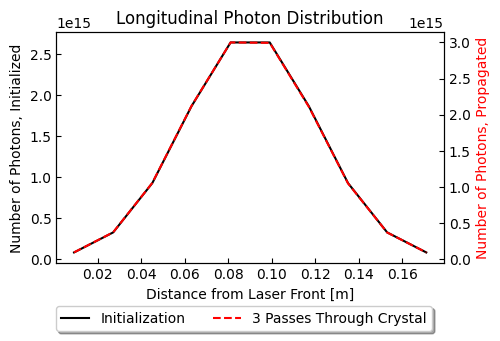

In [4]:
fig, ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()
ax1.plot(fig_x,photons_in_slice[:,0], 'k', label='Initialization')
ax2.plot(fig_x,photons_in_slice[:,num_propagate], '--r', label='{} Passes Through Crystal'.format(num_propagate))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=5)
ax1.tick_params(direction="in")
ax2.tick_params(direction="in")
ax1.set_xlabel(r'Distance from Laser Front [m]')
ax1.set_ylabel(r'Number of Photons, Initialized')
ax2.set_ylabel(r'Number of Photons, Propagated',color='r')
plt.title('Longitudinal Photon Distribution')